In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib.pyplot import subplots, style, rc, rc_context, close
from tqdm import tqdm
from venn import venn, pseudovenn
from collections import defaultdict
from itertools import count, islice
from functools import lru_cache
from argparse import Namespace

In [2]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.metrics import silhouette_score
from matplotlib.gridspec import GridSpec
%matplotlib inline

In [3]:
from scipy.cluster.hierarchy import cophenet
from scipy.stats import pearsonr, wilcoxon

In [4]:
from edgecaselib.formats import load_index, load_kmerscan
from edgecaselib.densityplot import interpret_arguments
from edgecaselib.util import natsorted_chromosomes
from pickle import dump, load
from os import path
from tempfile import NamedTemporaryFile
from subprocess import check_output, CalledProcessError
from pysam import AlignmentFile
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests
from scipy.ndimage import uniform_filter1d
from matplotlib.patches import FancyArrowPatch, Rectangle
from matplotlib.lines import Line2D

In [88]:
def wilcoxon_dropna(df, a, b):
    dfnona = df[[a, b]].dropna()
    try:
        yes = sum(dfnona[a] < dfnona[b])
        no = sum(dfnona[a] > dfnona[b])
        p = wilcoxon(dfnona[a], dfnona[b])[1]
        return yes, no, p
    except ValueError:
        return np.nan, np.nan, np.nan

In [86]:
SAMFILTERS = [["tract_anchor"], ["is_q"], 0]
ecx = load_index("../../hg38ext.fa.ecx")

In [101]:
SUBJECT_TO_TRIO = {
    "HG001": "NA12878",
    "HG002": "AshkenazimTrio", "HG003": "AshkenazimTrio", "HG004": "AshkenazimTrio",
    "HG005": "ChineseTrio", "HG006": "ChineseTrio", "HG007": "ChineseTrio",
}
P_CHROMS = ["chr2", "3ptel_1-500K_1_12_12", "4ptel_1-500K_1_12_12", "chr5", "chr9", "chr12", "17ptel_1_500K_1_12_12"]
MAXLEN = 1450
DATA_DIR = "../../../data/datasets/2021"

In [7]:
def squarify(narrowform):
    triu_fillna = narrowform.pivot(index="qname1", columns="qname2", values="relative_ld").fillna(0)
    return triu_fillna.T + triu_fillna

distances_narrowform = pd.read_csv(f"{DATA_DIR}/PacBio/haplotypes/levenshtein-p_arm.tsv", sep="\t", escapechar="#")

RAW_GLOBAL_LDS = {
    rname: squarify(distances_narrowform[distances_narrowform["rname"]==rname].drop(columns="rname"))
    for rname in distances_narrowform["rname"].drop_duplicates()
    if rname in P_CHROMS
}

In [8]:
KMERSCANNER_PKL = f"{DATA_DIR}/PacBio/kmerscanner-p_arm.pkl"
KMERSCANNER_DAT = f"{DATA_DIR}/PacBio/kmerscanner-p_arm.dat.gz"

if path.isfile(KMERSCANNER_PKL):
    with open(KMERSCANNER_PKL, mode="rb") as pkl:
        DENSITIES = load(pkl)
else:
    DENSITIES = load_kmerscan(KMERSCANNER_DAT, True, SAMFILTERS, 10)
    with open(KMERSCANNER_PKL, mode="wb") as pkl:
        dump(DENSITIES, pkl)

In [9]:
class GridFig():

    def __init__(self, width_ratios, height_ratios, scale=1):
        self.figure, _ = subplots(
            figsize=(sum(width_ratios)*scale, sum(height_ratios)*scale),
            ncols=0, nrows=0,
        )
        self.gs = GridSpec(
            ncols=len(width_ratios), wspace=0, width_ratios=width_ratios, 
            nrows=len(height_ratios), hspace=0, height_ratios=height_ratios,
            figure=self.figure,
        )
 
    def subplot(self, gridspec_slice, aspect="auto", frame=False):
        ax = self.figure.add_subplot(gridspec_slice, aspect=aspect)
        if frame is False:
            ax.set(frame_on=False)
        else:
            for spine in {"top", "right", "bottom", "left"} - set(frame):
                ax.spines[spine].set_visible(False)
        return ax

In [10]:
def plot_dendrogram(Z, gf):
    ax = gf.subplot(gf.gs[0,10])
    with rc_context({"lines.linewidth": .5}):
        dendrogram(
            Z, orientation="left",
            link_color_func=lambda x: "black", ax=ax,
        )
    ax.set(
        xticks=[], xlabel=None,
        yticks=[], ylabel=None,
        xlim=ax.get_xlim()[::-1],
        ylim=ax.get_ylim()[::-1],
    )

In [11]:
from matplotlib.colors import PowerNorm

def plot_heatmap(data2d, gf, cmap="gray_r", vmax=.15):
    ax = gf.subplot(gf.gs[0,9])
    sns.heatmap(data2d, cmap=cmap, cbar=False, vmin=0, vmax=vmax, ax=ax, norm=PowerNorm(gamma=.5))
    ax.set(xticks=[], yticks=[], xlabel=None, ylabel=None, xlim=ax.get_xlim()[::-1])

In [116]:
def cluster(lds, metric="correlation", method="ward"):
    Z = linkage(squareform(lds), metric=metric, method=method, optimal_ordering=False)
    leaves = dendrogram(Z, no_plot=True)["leaves"]
    data2d = lds.iloc[leaves, leaves].copy()
    dispatcher = pd.DataFrame(index=data2d.index)
    dispatcher.index.name = "read"
    to_subject = dispatcher.index.map(lambda s: s.split(":")[1])
    for subject in sorted(to_subject.drop_duplicates()):
        dispatcher[subject] = (to_subject==subject)
    return Z, data2d, dispatcher

In [13]:
def get_plottable_density_section(densities, chrom, motif, data2d, ecx):
    chrom_densities = densities[chrom]
    if motif is None:
        by_motif = chrom_densities[chrom_densities["motif"]=="CCCTAA"]
    else:
        by_motif = chrom_densities[chrom_densities["motif"]==motif]
    section = by_motif.set_index("name").reindex(data2d.index).iloc[:,8:].copy()
    if motif is None:
        section = (~section.isnull()).astype(int) / 3
    section.columns = section.columns.astype(int)
    anchor = ecx.loc[
        (ecx["rname"]==chrom) & (ecx["flag"]==0x4000) & (ecx["prime"]==5),
        "pos",
    ].iloc[0]
    return section[[c for c in section.columns if c<=anchor]]

In [14]:
def get_absentees(lds, densities, chrom, ecx):
    raw_section = get_plottable_density_section(densities, chrom, "CCCTAA", lds, ecx)
    nulls = raw_section.isnull().all(axis=1)
    return nulls[nulls].index

In [15]:
def section_to_RGB(ps, color, alpha_factor=1.2):
    return np.transpose(
        np.array([
            np.full_like(ps, color[0]),
            np.full_like(ps, color[1]),
            np.full_like(ps, color[2]),
            np.clip(ps*alpha_factor, a_min=None, a_max=1),
        ]),
        axes=(1, 2, 0),
    )

In [16]:
def draw_fancy_arrow(
    y, start, end, ax, lw=.25,
    csty="angle3,angleA=45,angleB=-45",
    asty="Simple, tail_width=.25, head_width=2, head_length=3"
):
    ax.add_patch(FancyArrowPatch(
        (start, y), (end, y),
        connectionstyle=csty,
        arrowstyle=asty,
        lw=lw, color="#888", clip_on=False,
    ))

In [17]:
POPULATION_COLORS = {
    "HG001": "black",
    "HG002": "green", "HG003": "green", "HG004": "green",
    "HG005": "steelblue", "HG006": "steelblue", "HG007": "steelblue",
}

def plot_subjects(dispatcher, gf, s=10):
    for i, subject in enumerate(sorted(SUBJECT_TO_TRIO)):
        sax = gf.subplot(gf.gs[0,1+i])
        sax.plot([0, 0], [0, len(dispatcher)], lw=.5, color="#888")
        if subject in dispatcher:
            truthiness = dispatcher[subject].reset_index(drop=True)
            positions = truthiness[truthiness].index
            for x in [-.1, 0, .1]:
                sax.scatter(x=[x]*len(positions), y=positions, marker="_", s=s, color=POPULATION_COLORS[subject])
        sax.set(
            xticks=[0], xticklabels=[subject+"  "],
            yticks=[], xlabel=None, ylabel=None,
            xlim=(-.5, .5),
            ylim=(len(dispatcher), -1),
        )
        for tick in sax.get_xticklabels():
            tick.set_rotation(90)
        if subject in {"HG002", "HG005"}:
            draw_fancy_arrow(len(dispatcher), 1, 0, sax)
            draw_fancy_arrow(len(dispatcher), 2, 0, sax)
        sax.tick_params(axis="both", which="both", length=0)

In [124]:
IMSHOW_PALETTE = {
    None: [.7, .7, .7],
    "CCCTAA": [.1, .5, .2],
    "CCCTCA": [1, 1, 0],
    "CCCCTAA": [.8, .4, .6],
    "CCTAA": [.5, .9, 1],
}

def plot_densities(densities, chrom, data2d, ecx, gf, extent, bin_size=100):
    ax = gf.subplot(gf.gs[0,0])
    for motif, color in IMSHOW_PALETTE.items():
        ps = get_plottable_density_section(densities, chrom, motif, data2d, ecx).values
        breakat = MAXLEN // 100
        if ps.shape[1] < MAXLEN:
            ps = np.pad(ps, ((0, 0), (MAXLEN-ps.shape[1], 0)))
        elif ps.shape[1] > MAXLEN:
            ps = ps[:,-MAXLEN:]
        pa = section_to_RGB(np.clip(uniform_filter1d(ps[:,::-1], 5, 1)[:,::-1], a_min=0.0, a_max=1.0), color, 1.5)
        ax.imshow(pa, extent=extent, interpolation="nearest")
    ticklabels=(-np.linspace(MAXLEN//100, 0, MAXLEN//100+1).astype(int)).astype(str)
    fullaxislen = len(ticklabels)
    ticklabels = ticklabels[-breakat-1:]
    xmin, xmax = extent[:2]
    ax.set(
        xticks=np.linspace(xmin, xmax, MAXLEN//100+1)[-breakat-1:],
        xticklabels=ticklabels,
        xlabel="Kbp of telomeric tract",
        yticks=[], ylabel=None,
    )
    ax.tick_params(axis="both", which="both", length=0)
    ax.tick_params(axis="x", which="both", length=3)
    ax.axhline(0, 1-(breakat+1)/fullaxislen, 1, lw=1, c="black")

In [20]:
@lru_cache(maxsize=None)
def convname(cn):
    match = re.search(r'^\d+', cn)
    if match:
        return match.group() + "p"
    else:
        return cn.split("chr")[1] + "p"

In [114]:
def process_lds(raw_global_lds, chrom, densities, ecx, no_plot=False, scale=.2):
    lds = raw_global_lds[chrom].copy()
    absentees = get_absentees(lds, densities, chrom, ecx)
    lds.drop(index=absentees, columns=absentees, inplace=True)
    Z, data2d, dispatcher = cluster(lds, metric="euclidean", method="ward")
    if no_plot:
        gf = None
    else:
        h = 6*len(lds)/50
        w = 30
        gf = GridFig([w]+[.85]*7+[.3,h,h/3], [h], scale=scale)
        plot_dendrogram(Z, gf=gf)
        plot_heatmap(data2d, gf=gf)
        plot_subjects(dispatcher, gf=gf, s=7)
        plot_densities(densities, chrom, data2d, ecx, gf=gf, extent=[0,w,0,h])
        if len(chrom) > 11:
            name = "{} ({})".format(convname(chrom), chrom[:6]+"…")
        else:
            name = "{} ({})".format(convname(chrom), chrom)
        gf.figure.get_axes()[-10].set_ylabel(name, fontsize=13)
        gf.figure.get_axes()[-10].yaxis.set_label_position("right")
    return lds, Z, data2d, dispatcher, gf

In [22]:
def cophenetic_correlation(lds, Z):
    r, p = pearsonr(squareform(lds), cophenet(Z))
    return r, max(p, 5e-324) # p-value of zero is just a rounding issue

In [23]:
def fixup_labels(gf, chrom):
    if chrom == "chr2":
        gf.figure.get_axes()[1].set_title("Pairwise relative\nLevenshtein distances", fontsize=13, loc="left")
        gf.figure.get_axes()[5].set_title("Subjects", fontsize=13)
        gf.figure.get_axes()[9].set_title("Motif densities", loc="right", fontsize=13)
    if chrom != "17ptel_1_500K_1_12_12":
        for ax in gf.figure.get_axes()[:-1]:
            ax.set(xticklabels=[], xlabel=None)
        gf.figure.get_axes()[-1].set(xlabel=None)

In [24]:
read_to_category = lambda dispatcher, pos: pd.Series(
    index=dispatcher.index,
    data=dispatcher.index.map(lambda s: s.split(":")[pos])
)

In [25]:
def count_subtrees(dispatcher):
    read_to_trio = read_to_category(dispatcher, 0)
    running_trio = None
    trio_runs = defaultdict(int)
    run = 0
    for trio in read_to_trio:
        if trio != running_trio:
            if run:
                trio_runs[running_trio] += 1
            running_trio, run = trio, 1
        else:
            run += 1
    if run:
        trio_runs[running_trio] += 1
    return trio_runs

In [26]:
reindex_to = lambda row, rtc, cat: row.reindex(rtc[rtc==cat].index).dropna()
reindex_in = lambda row, rtc: row.reindex(rtc[rtc==rtc[row.name]].index).dropna()
reindex_out = lambda row, rtc: row.reindex(rtc[rtc!=rtc[row.name]].index).dropna()

In [27]:
def get_closest_distances(lds, dispatcher):
    read_to_trio = read_to_category(dispatcher, 0)
    read_to_subject = read_to_category(dispatcher, 1)
    return lds.apply(
        lambda row: pd.Series({
            "subject": reindex_in(row, read_to_subject).drop(index=row.name).min(),
            "trio": reindex_in(reindex_out(row, read_to_subject), read_to_trio).min(),
            "outgroup": reindex_out(row, read_to_trio).min(),
        }),
        axis=1,
    )

In [28]:
def subject_to_subject_lds(lds, dispatcher, a, b):
    read_to_subject = read_to_category(dispatcher, 1)
    return lds.loc[read_to_subject[read_to_subject==a].index, read_to_subject[read_to_subject==b].index]

In [29]:
def get_closest_family_distances(lds, dispatcher, **kwargs):
    target, test, control = list(kwargs)
    return pd.DataFrame({
        f"{test} to {target}": subject_to_subject_lds(lds, dispatcher, kwargs[test], kwargs[target]).min(axis=1),
        f"{test} to {control}": subject_to_subject_lds(lds, dispatcher, kwargs[test], kwargs[control]).min(axis=1),
    })

In [30]:
def process_distances(lds, dispatcher):
    closest_distances = get_closest_distances(lds, dispatcher)
    ashkenazim_from_father = get_closest_family_distances(lds, dispatcher, son="HG002", father="HG003", mother="HG004")
    ashkenazim_from_mother = get_closest_family_distances(lds, dispatcher, son="HG002", mother="HG004", father="HG003")
    chinese_from_father = get_closest_family_distances(lds, dispatcher, son="HG005", father="HG006", mother="HG007")
    chinese_from_mother = get_closest_family_distances(lds, dispatcher, son="HG005", mother="HG007", father="HG006")
    return (
        closest_distances,
        ashkenazim_from_father, ashkenazim_from_mother,
        chinese_from_father, chinese_from_mother,
        *wilcoxon_dropna(closest_distances, "subject", "trio"),
        *wilcoxon_dropna(closest_distances, "subject", "outgroup"),
        *wilcoxon_dropna(closest_distances, "trio", "outgroup"),
        *wilcoxon_dropna(ashkenazim_from_father, "father to son", "father to mother"),
        *wilcoxon_dropna(ashkenazim_from_mother, "mother to son", "mother to father"),
        *wilcoxon_dropna(chinese_from_father, "father to son", "father to mother"),
        *wilcoxon_dropna(chinese_from_mother, "mother to son", "mother to father"),
    )

In [ ]:
stats = pd.DataFrame(columns=[
    "NA12878", "AshkenazimTrio", "ChineseTrio",
    "cr", "cp",
    "s2t_p", "s2o_p", "t2o_p", "aff_p", "afm_p", "cff_p", "cfm_p",
])

cd_list, aff_list, afm_list, cff_list, cfm_list = [], [], [], [], []
NO_PLOT = False

for chrom in tqdm(RAW_GLOBAL_LDS):
    try:
        lds, Z, data2d, dispatcher, gf = process_lds(RAW_GLOBAL_LDS, chrom, DENSITIES, ecx, no_plot=NO_PLOT, scale=.2)
    except ValueError: # too few observations
        continue
    try:
        cr, cp = cophenetic_correlation(lds, Z)
    except ValueError: # too few observations
        cr, cp = np.nan, np.nan
    if not NO_PLOT:
        fixup_labels(gf, chrom)
        gf.figure.savefig(
            f"{DATA_DIR}/PacBio/haplotypes/clusters-p_arm/"+chrom+".pdf", bbox_inches="tight",
        )
        close(gf.figure)
    cd, aff, afm, cff, cfm, _, _, s2t_p, _, _, s2o_p, _, _, t2o_p, _, _, aff_p, _, _, afm_p, _, _, cff_p, _, _, cfm_p = (
        process_distances(lds, dispatcher)
    )
    cd_list.append(cd)
    aff_list.append(aff)
    afm_list.append(afm)
    cff_list.append(cff)
    cfm_list.append(cfm)
    stats.loc[chrom] = [
        np.nan, np.nan, np.nan,
        cr, cp,
        s2t_p, s2o_p, t2o_p, aff_p, afm_p, cff_p, cfm_p,
    ]
    for trio, subtree_count in count_subtrees(dispatcher).items():
        stats.loc[chrom, trio] = subtree_count

  0%|          | 0/7 [00:00<?, ?it/s]/home/kirill/usr/opt/miniconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
 14%|█▍        | 1/7 [00:08<00:53,  8.90s/it]/home/kirill/usr/opt/miniconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
 29%|██▊       | 2/7 [00:10<00:25,  5.11s/it]/home/kirill/usr/opt/miniconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
 43%|████▎     | 3/7 [00:12<00:16,  4.04s/it]

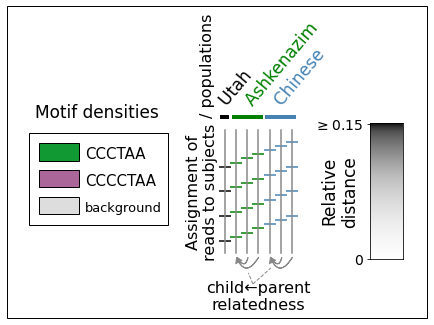

In [84]:
legend, axs = subplots(figsize=(6.7, 2.5), ncols=4, gridspec_kw=dict(width_ratios=(4.2, 4.5, 1, 1), wspace=.1))

axs[3].imshow(np.vstack([np.linspace(0, 1, 256)**.5]).T, cmap="Greys_r", aspect="auto")
axs[3].set(xticks=[], yticks=[0, 255])
axs[3].set_yticklabels(["$\geq{}0.15$", "0"], fontsize=14)
axs[3].text(x=-.2, y=128, s="Relative\ndistance\n", rotation=90, ha="right", va="center", fontsize=17)

axs[2].set(frame_on=False, xticks=[], yticks=[])

for x, subject in enumerate(sorted(SUBJECT_TO_TRIO)):
    axs[1].plot([x, x], [0, 1], color="#888", lw=1.5)
    axs[1].scatter([x]*4, np.linspace(.1, .7, 4)+x/30, color=POPULATION_COLORS[subject], marker="_", s=125)

axs[1].set(xlim=(-4.5, 8.5), xticks=[], yticks=[])
twiny = axs[1].twiny()
twiny.set(xlim=(-4.5, 8.5), xticks=[])
for tick in twiny.get_xticklabels():
    tick.set_rotation(80)
twiny.tick_params(axis="both", which="both", length=0)
for spine in "top", "bottom", "right", "left":
    axs[1].spines[spine].set_visible(False)
    twiny.spines[spine].set_visible(False)
axs[1].text(x=-2, y=.5, s="Assignment of\nreads to subjects", rotation=90, fontsize=16, ha="center", va="center")
axs[1].text(x=-1.5, y=1.1, s="/ populations", rotation=90, ha="center", va="bottom", fontsize=16)

csty1 = "angle3,angleA=80,angleB=-60"
csty2 = "angle3,angleA=60,angleB=-70"
asty = "Simple, tail_width=.25, head_width=7, head_length=5"
draw_fancy_arrow(-0.02, 2.1, 1, axs[1], lw=1, csty=csty1)
draw_fancy_arrow(-0.02, 3.1, 1, axs[1], lw=1, asty=asty, csty=csty2)
draw_fancy_arrow(-0.02, 5.1, 4, axs[1], lw=1, csty=csty1)
draw_fancy_arrow(-0.02, 6.1, 4, axs[1], lw=1, asty=asty, csty=csty2)

axs[1].text(x=2.95, y=-.35, s="child{}parent\nrelatedness".format(chr(0x2190)), va="center", ha="center", fontsize=16)
line = Line2D((2.5, 4.1), (-.25, -.12), lw=1, ls="--", color="#888")
line.set_clip_on(False)
axs[1].add_line(line)
line = Line2D((2.5, 2.1), (-.25, -.16), lw=1, ls="--", color="#888")
line.set_clip_on(False)
axs[1].add_line(line)

line = Line2D((-.2, .2), (1.1, 1.1), lw=4, color=POPULATION_COLORS["HG001"])
line.set_clip_on(False)
axs[1].add_line(line)
axs[1].text(x=.7, y=1.1, s="  Utah", ha="center", va="bottom", rotation=50, fontsize=17, color=POPULATION_COLORS["HG001"])

line = Line2D((.8, 3.2), (1.1, 1.1), lw=4, color=POPULATION_COLORS["HG002"])
line.set_clip_on(False)
axs[1].add_line(line)
axs[1].text(x=4.8, y=1.1, s="  Ashkenazim", ha="center", va="bottom", rotation=50, fontsize=17, color=POPULATION_COLORS["HG002"])

line = Line2D((3.8, 6.2), (1.1, 1.1), lw=4, color=POPULATION_COLORS["HG005"])
line.set_clip_on(False)
axs[1].add_line(line)
axs[1].text(x=6.4, y=1.1, s="  Chinese", ha="center", va="bottom", rotation=50, fontsize=17, color=POPULATION_COLORS["HG005"])

INCLUDE_FIVEMER = False

axs[0].add_patch(Rectangle((0,3), 1.5, .65, facecolor="#119933", edgecolor="black"))
axs[0].text(x=1.75, y=3.25, s="CCCTAA", fontsize=15, va="center")
axs[0].add_patch(Rectangle((0,2), 1.5, .65, facecolor="#AA6699", edgecolor="black"))
axs[0].text(x=1.75, y=2.25, s="CCCCTAA", fontsize=15, va="center")
if INCLUDE_FIVEMER:
    axs[0].add_patch(Rectangle((0,1), 1.5, .65, facecolor="#88CCEE", edgecolor="black"))
    axs[0].text(x=1.75, y=1.25, s="CCTAA", fontsize=15, va="center")
    axs[0].add_patch(Rectangle((0,0), 1.5, .65, facecolor="#DDDDDD", edgecolor="black"))
    axs[0].text(x=1.75, y=0.25, s="background", fontsize=13, va="center")
else:
    axs[0].add_patch(Rectangle((0,1), 1.5, .65, facecolor="#DDDDDD", edgecolor="black"))
    axs[0].text(x=1.75, y=1.25, s="background", fontsize=13, va="center")
    axs[0].set(frame_on=False)
    axs[0].add_patch(Rectangle((-.4, .6), 5.3, 3.45, facecolor="none", edgecolor="black", lw=1, clip_on=False))
axs[0].set(xticks=[], yticks=[], xlim=(-.4, 4.8), ylim=(-0.7, 4.4))
axs[0].set_title("Motif densities", fontsize=17)

legend.add_artist(Rectangle((.08, -.2), .87, 1.73, edgecolor="black", facecolor="none"))

legend.savefig(f"{DATA_DIR}/PacBio/haplotypes/clusters-p_arm/legend.pdf", bbox_inches="tight")

In [118]:
PRINT_NS = False

if PRINT_NS:
    format_pval = lambda p: "ns" if (p >= .05) else ("<1.0e-300" if (p < 1e-300) else format(p, ".1e"))
else:
    format_pval = lambda p: format(p, ".2f") if (p >= .05) else ("<1.0e-300" if (p < 1e-300) else format(p, ".1e"))

In [119]:
st = stats.reindex(natsorted_chromosomes(stats.index)).copy()
st.index.name = "contig"
tc = st.iloc[:,:3].values.flatten()
tc = tc[~np.isnan(tc)]
print("Max subtree count:", stats.iloc[:,:3].max(axis=0).sort_values().iloc[[-1]].to_string())
print("Median subtree count:", np.median(tc))

Max subtree count: AshkenazimTrio    24.0
Median subtree count: 3.0


In [120]:
st = stats.reindex(natsorted_chromosomes(stats.index)).copy()
st.index.name = "contig"
st = st.iloc[:,3:].reset_index()
st.insert(loc=0, column="chromosome", value=st["contig"].apply(convname))

coph = st.iloc[:,:4].copy()
coph["cp"] = multipletests(coph["cp"], method="bonferroni")[1]
coph["r"] = coph["cr"].apply(lambda r: format(r, ".2f"))
coph["p"] = coph["cp"].apply(format_pval)
coph.drop(columns=["cr", "cp"])

,chromosome,contig,r,p
0,2p,chr2,0.63,6.8e-165
1,3p,3ptel_1-500K_1_12_12,0.61,1.4e-235
2,4p,4ptel_1-500K_1_12_12,0.49,<1.0e-300
3,5p,chr5,0.76,2.4e-194
4,9p,chr9,0.73,7.3e-119
5,12p,chr12,0.78,2.5e-214
6,17p,17ptel_1_500K_1_12_12,0.94,<1.0e-300


In [170]:
with open("for_wilcoxon-p_arm.pkl", mode="wb") as pkl:
    P = Namespace(cd_list=cd_list, aff_list=aff_list, afm_list=afm_list, cff_list=cff_list, cfm_list=cfm_list)
    dump(P, pkl)

In [121]:
cd_all = pd.concat(cd_list)
print(len(cd_all[cd_all["subject"]>cd_all["outgroup"]]), len(cd_all[cd_all["subject"]>cd_all["outgroup"]])/3729)
inter_reads = cd_all[cd_all["subject"]>=cd_all["outgroup"]*2].index
inter_dispatcher = pd.DataFrame(index=inter_reads, data={"subject": inter_reads.map(lambda s: s.split(":")[1])})
print(len(inter_dispatcher), len(inter_dispatcher)/3729)
inter_dispatcher["subject"].value_counts()

148 0.039688924644676854
148 0.039688924644676854


HG005    34
HG002    33
HG006    25
HG007    23
HG001    21
HG003    11
HG004     1
Name: subject, dtype: int64

In [122]:
inter_dispatcher["chromosome"] = np.nan
inter_dispatcher["rname"] = np.nan

for chrom, lds in RAW_GLOBAL_LDS.items():
    for name in lds.index:
        if name in inter_dispatcher.index:
            inter_dispatcher.loc[name, "rname"] = chrom
inter_dispatcher["chromosome"] = inter_dispatcher["rname"].apply(convname)

In [123]:
inter_counts = inter_dispatcher.groupby(["subject", "chromosome"], as_index=False).count().pivot(
    index="subject", columns="chromosome", values="rname",
)
inter_counts = inter_counts[natsorted_chromosomes(inter_counts.columns)].applymap(lambda x: "" if np.isnan(x) else str(int(x)))
inter_counts

chromosome,2p,3p,4p,9p,12p,17p
subject,,,,,,
HG001,,3,14,1,,3
HG002,,1,31,1,,
HG003,,,8,,1,2
HG004,,,1,,,
HG005,1,,20,1,,12
HG006,,,5,,1,19
HG007,,4,3,,,16
